This notebook demonstrates how the Gliquid code can be used to adjust the prediction of a binary phase diagram with known datapoints taken from measurements.

*WORK IN PROGRESS, WILL BE UPDATED IN NEXT (MAYBE?) VERSION*

In [ ]:
import os
import plotly.graph_objects as go
import sympy as sp
from gliquid.binary import BinaryLiquid, BLPlotter

# Set the environmental variables for cache directory (where data files are stored) and Materials Project API keys.
os.environ["NEW_MP_API_KEY"] = "YOUR API KEY HERE"

In [2]:
# Instantiate a BinaryLiquid object with a guess for parameter values
parameter_guesses = [-175000, -20, 23000, -12] # [Enthalpy of Mixing, Entropy of Mixing, Enthalpy Skew, Entropy Skew]
ce_ir_system = BinaryLiquid.from_cache('Ce-Ir', params=parameter_guesses)
blp = BLPlotter(ce_ir_system)
blp.show('pred')

Retrieving ThermoDoc documents:   0%|          | 0/19 [00:00<?, ?it/s]

Ce: H_fusion = 6200.0 J/mol, T_fusion = 1071.0 K, T_vaporization = 3633.15 K
Ir: H_fusion = 41120.0 J/mol, T_fusion = 2719.0 K, T_vaporization = 4701.15 K

Reading MPDS json from entry at https://mpds.io/entry/C904533...



In [5]:
def adjust_L0a_from_known_point(bl: BinaryLiquid, known_point: list, tol=10):
    """
    From a known (measured) point, use a bisection algorithm to find the value of L0_a which will generate a liquidus 
    which intersects the known point. 
    """
    # Get present MAE and parameters
    mae, _ = bl.calculate_deviation_metrics()
    print(f"Current complete liquidus MAE: {int(mae)}K")
    print(f"Current parameters: {bl._params}")

    def get_temp_error():
        bl.update_phase_points()
        gen_liq = bl.phases[-1]['points']
        gen_liq_point = min(gen_liq, key=lambda x: abs(x[0] - known_point_k[0]))
        return gen_liq_point[1] - known_point_k[1]

    # Find the temperature error of the generated liquidus to the known point
    known_point_k = [known_point[0], known_point[1] + 273.15] # Assume that known_point is given in Celsius
    temp_error = get_temp_error()
    print(f"The liquidus point generated from current parameter guesses is off by {int(temp_error)} K")

    # Find the values of L0_a that generate a liquidus above and below the known point (at the same composition).
    # Note: this algorithm as-written will only work for L0_a < 0
    ub, lb = None, None
    while not (lb and ub):
        if temp_error > 0:
            ub = bl.get_L0_a()
            bl._params[0] *= 2
        else:
            lb = bl.get_L0_a()
            bl._params[0] /= 2
        temp_error = get_temp_error()

    # Search between the boundary L0_a values to find value that generates a liquidus with temperature error below 'tol'
    # 'tol' is the temperature (Celsius / Kelvin) precision in which the generated liquidus point error must fall below
    while abs(temp_error) > tol:
        mid = 0.5 * (lb + ub)
        bl._params[0] = mid
        temp_error = get_temp_error()
        if temp_error > 0:
            ub = mid
        else:
            lb = mid
                
    mae, _ = bl.calculate_deviation_metrics()
    print(f"Adjusted complete liquidus MAE: {int(mae)}K")
    print(f"Adjusted parameters: {bl._params}")

Current complete liquidus MAE: 567K
Current parameters: [-175000, -20, 23000, -12]
The liquidus point generated from current parameter guesses is off by 221 K
Adjusted complete liquidus MAE: 381K
Adjusted parameters: [-194140.625, -20, 23000, -12]


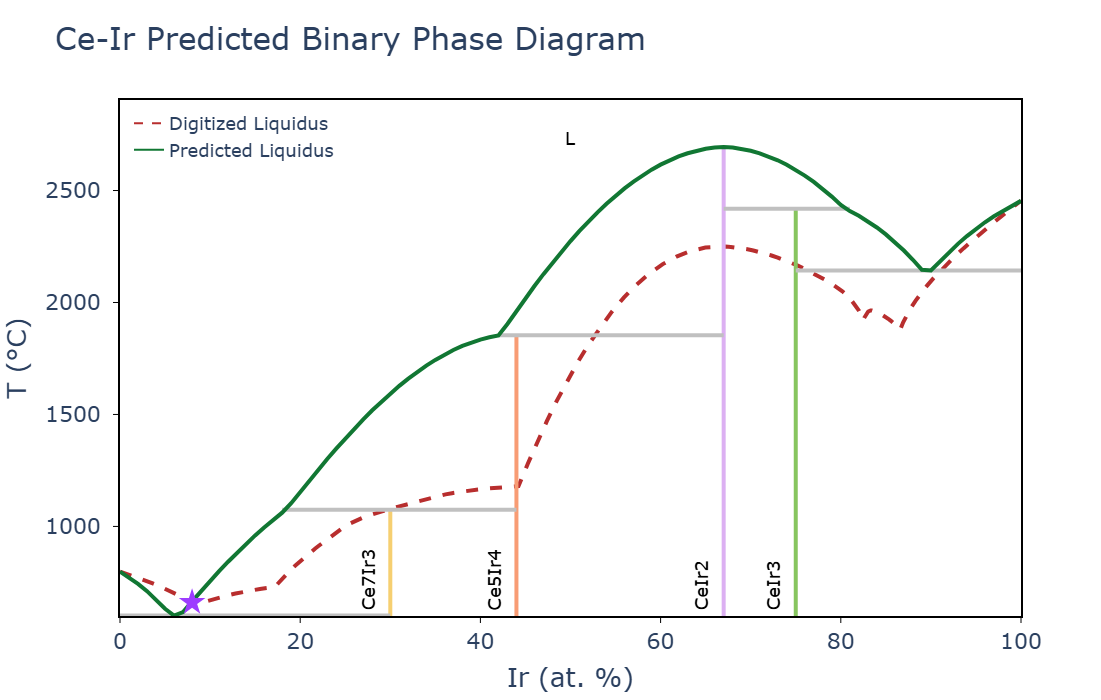

Current complete liquidus MAE: 567K
Current parameters: [-175000, -20, 23000, -12]
The liquidus point generated from current parameter guesses is off by 792 K
Adjusted complete liquidus MAE: 106K
Adjusted parameters: [-240625.0, -20, 23000, -12]


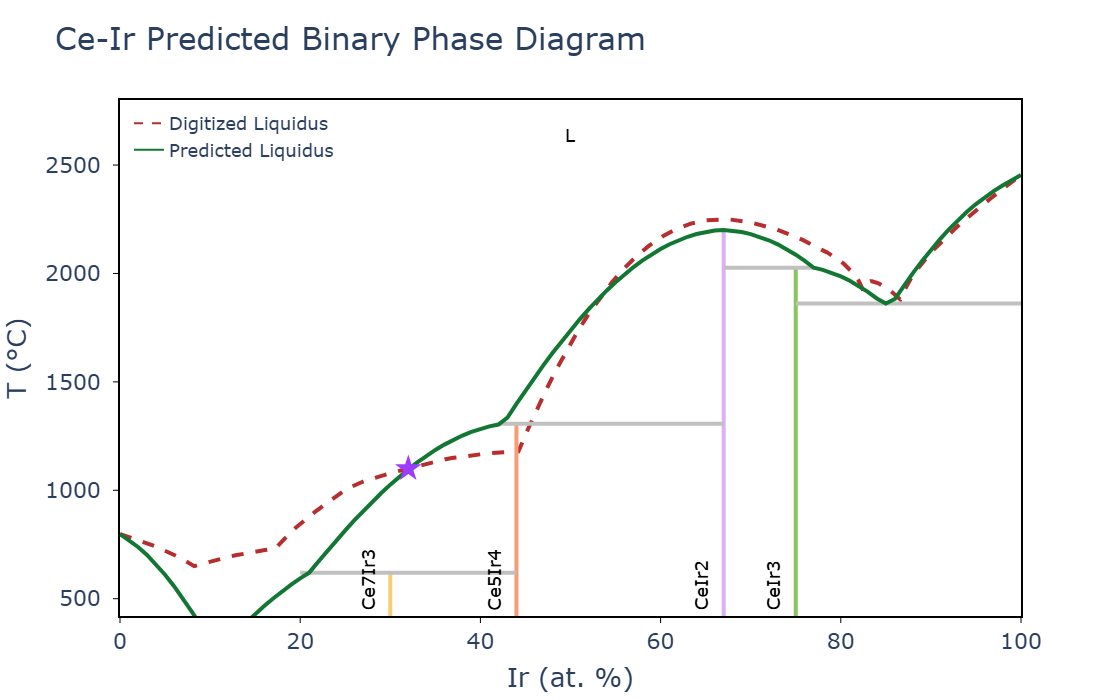

In [6]:
known_points = [[0.08, 661], [0.32, 1100]]

ce_ir_system.update_params(parameter_guesses)
adjust_L0a_from_known_point(ce_ir_system, known_points[0])

fig = blp.get_plot('pred+liq')
fig.add_trace(go.Scatter(
    x=[known_points[0][0]*100], y=[known_points[0][1]],
    mode='markers',
    marker=dict(color='#9D3CFF', size=20, symbol='star'),
    text='known point #1',
    showlegend=False,
))
fig.show()

ce_ir_system.update_params(parameter_guesses)
adjust_L0a_from_known_point(ce_ir_system, known_points[1])

fig = blp.get_plot('pred+liq')
fig.add_trace(go.Scatter(
    x=[known_points[1][0]*100], y=[known_points[1][1]],
    mode='markers',
    marker=dict(color='#9D3CFF', size=20, symbol='star'),
    text='known point #2',
    showlegend=False
))
fig.show()

In [2]:
def adjust_liquidus_from_known_points(bl: BinaryLiquid, known_points: list):
    # Get present MAE and parameters
    original_liq = [p for p in bl.digitized_liq]
    mae, _ = bl.calculate_deviation_metrics()
    print(f"Current complete liquidus MAE: {int(mae)}K")
    print(f"Current parameters: {bl._params}")

    bl.digitized_liq = [[p[0], p[1] + 273.15] for p in known_points]
    mae, _ = bl.calculate_deviation_metrics()
    print(f"Known points (Kelvin): {bl.digitized_liq}")
    print(f"Liquidus MAE from known points: {int(mae)}K")

    a, c = sp.symbols('a c')
    bl.guess_symbols = (a, c)
    l0_a_itl = bl.get_L0_a()
    l1_a_itl = bl.get_L1_a()

    initial_guesses = [[l0_a_itl * 0.9, l1_a_itl * 0.9],
                       [l0_a_itl * 1.1, l1_a_itl * 0.9],
                       [l0_a_itl * 0.9, l1_a_itl * 1.1]]
    mae, _, _ = bl.nelder_mead(tol=1, initial_guesses=initial_guesses, verbose=False)
    print(f"Liquidus MAE from known points: {int(mae)}K")
    bl.digitized_liq = original_liq
    mae, _ = bl.calculate_deviation_metrics()
    print(f"Adjusted complete liquidus MAE: {int(mae)}K")
    print(f"Adjusted parameters: {bl._params}")

In [8]:
known_points = [[0.08, 661], [0.32, 1100]]

ce_ir_system.update_params(parameter_guesses)
adjust_liquidus_from_known_points(ce_ir_system, known_points)
fig = blp.get_plot('pred+liq')

for i, point in enumerate(known_points):
    fig.add_trace(go.Scatter(
        x=[point[0]*100], y=[point[1]],
        mode='markers',
        marker=dict(color='#9D3CFF', size=20, symbol='star'),
        text=f'known point #{i+1}',
        showlegend=False,
    ))
fig.show()

Current complete liquidus MAE: 567K
Current parameters: [-175000, -20, 23000, -12]
Known points (Kelvin): [[0.08, 934.15], [0.32, 1373.15]]
Liquidus MAE from known points: 505K
--- Beginning Nelder-Mead optimization ---
--- Nelder-Mead converged in 32.43948984146118 seconds ---
Mean temperature deviation per point between liquidus curves = 6.737362201842838 

Liquidus MAE from known points: 6K
Adjusted complete liquidus MAE: 215K
Adjusted parameters: [-250768.45220453065, -20, 99848.73328456434, -12]


In [2]:
def adjust_liquidus_from_invariant_point(bl: BinaryLiquid, known_eutectic_point: list):
    # Get present MAE and parameters
    mae, _ = bl.calculate_deviation_metrics()
    print(f"Current complete liquidus MAE: {int(mae)}K")
    print(f"Current parameters: {bl._params}")

    # Find the temperature error of the generated liquidus to the known eutectic point
    known_eutectic_point[1] += 273.15 # Assume that known_point is given in Celsius
    gen_liq = bl.phases[-1]['points']
    gen_liq_point = min(gen_liq, key=lambda x: abs(x[0] - known_eutectic_point[0]))
    temp_error = gen_liq_point[1] - known_eutectic_point[1]
    print(f"The liquidus point generated from current parameter guesses is off by {int(temp_error)} K")

    # Get the DFT phases adjacent to the eutectic point
    lhs_phases = [phase for phase in bl.phases[:-1] if phase['comp'] < known_eutectic_point[0]]
    adj_lhs_phase = min(lhs_phases, key=lambda x: abs(x['comp'] - known_eutectic_point[0]))
    rhs_phases = [phase for phase in bl.phases[:-1] if phase['comp'] > known_eutectic_point[0]]
    adj_rhs_phase = min(rhs_phases, key=lambda x: abs(x['comp'] - known_eutectic_point[0]))
 
    # Set up the symbolic equation and first derivative of the liquid free energy
    xb, t, a, b, c, d = sp.symbols('x t a b c d')
    xa = 1 - xb

    R = 8.314
    Ga = (bl.component_data[bl.components[0]][0] -
            t * bl.component_data[bl.components[0]][0] / bl.component_data[bl.components[0]][1])
    Gb = (bl.component_data[bl.components[1]][0] -
            t * bl.component_data[bl.components[1]][0] / bl.component_data[bl.components[1]][1])
    L0 = a + b * t
    L1 = c + d * t

    G_ideal = R * t * (xa * sp.log(xa) + xb * sp.log(xb))
    G_xs = L0 * (xa * xb) + L1 * (xa * xb * (xa - xb))
    G_liq = Ga * xa + Gb * xb + G_ideal + G_xs
    G_prime = sp.diff(G_liq, xb)

    # Set up the invariant equation: dG/dx @ eutectic point = ΔG/ΔX from phases adjacent to eutectic point
    x1, g1 = adj_lhs_phase['comp'], adj_lhs_phase['energy']
    x2, t2 = known_eutectic_point[0], known_eutectic_point[1]
    x3, g3 = adj_rhs_phase['comp'], adj_rhs_phase['energy']
    inv_eqn = sp.Eq(G_prime.subs({xb: x2, t: t2}), (g3 - g1) / (x3 - x1))

    # With one constraint, we can solve for the value of a single parameter with a 'guess' for the other three
    # Here, the 'guessed' parameters are b=L0_b, c=L1_a, d=L1_b. We are solving for the value of a=L0_a
    bl.guess_symbols = (b, c, d)
    bl.constraints = sp.solve([inv_eqn], (a))
    mae = bl.f([bl.get_L0_b(), bl.get_L1_a(), bl.get_L1_b()]) # This will update L0_a and return the liquidus MAE
    print(f"Adjusted complete liquidus MAE: {int(mae)}K")
    print(f"Adjusted parameters: {bl._params}")

In [3]:
ce_ir_system.update_params(parameter_guesses)
adjust_liquidus_from_invariant_point(ce_ir_system, [0.08, 650])

blp = BLPlotter(ce_ir_system)
blp.show('pred+liq')

NameError: name 'ce_ir_system' is not defined

In [18]:
parameter_guesses = [-175000, -20, 23000, -12] # [Enthalpy of Mixing, Entropy of Mixing, Enthalpy Skew, Entropy Skew]
ce_ir_system = BinaryLiquid.from_cache('Ce-Ir', params=parameter_guesses)
ce_ir_system.update_phase_points()

fitting_data = ce_ir_system.fit_parameters(n_opts=3)
print(f"Best fitted parameters: {ce_ir_system._params}")
best_fit_mae = min(fitting_data, key=lambda x: x['mae'])['mae']
print(f"Best fitted MAE: {best_fit_mae}K")
blp = BLPlotter(ce_ir_system)
blp.show('fit+liq')

Ce: H_fusion = 6200.0 J/mol, T_fusion = 1071.0 K, T_vaporization = 3633.15 K
Ir: H_fusion = 41120.0 J/mol, T_fusion = 2719.0 K, T_vaporization = 4701.15 K

Reading MPDS json from entry at https://mpds.io/entry/C904533...

--- Beginning Nelder-Mead optimization ---
--- Nelder-Mead converged in 10.73818039894104 seconds ---
Mean temperature deviation per point between liquidus curves = 58.07166060479998 

--- Beginning Nelder-Mead optimization ---
--- Nelder-Mead converged in 11.155130386352539 seconds ---
Mean temperature deviation per point between liquidus curves = 39.33692188980147 

--- Beginning Nelder-Mead optimization ---
--- Nelder-Mead converged in 12.637938976287842 seconds ---
Mean temperature deviation per point between liquidus curves = 100.78106040814693 

Best fitted parameters: [-245103.11269772984, -19.839482307434082, 169977.6364387978, -82.8556227684021]
Best fitted MAE: 39.33692188980147K


In [2]:
# Goal 1: Parameter values don't change much. Criteria for nelder-mead exit must be relaxed.
# Goal 2: L_b params must have realistic values. Exit earlier if overfitting is likely to occur.
# Testing suite: Sample liquidus 1. randomly, 2. by specified criteria. Plot final optimized MAE vs. number of points sampled.
# Report normalized metrics + others and run on several systems. Compare for trend.


# Method: constraintless optimization. L_a -> L_b. 
# guess symbols: a, c
# L0_a_init = L0_a_pred + L0_b_pred * Tmean. 
# L1_a_init = L1_a_pred + L1_b_pred * Tmean.
# Optimize with some criteria.
# guess symbols: b, d
# L0_b_init = L0_b_pred
# L1_b_init = L1_b_pred
# Disincentivize overfitting by penalizing large L0_b and L1_b values.

def optimize_predicted_params(bl: BinaryLiquid, known_points: list):
        # Get present MAE and parameters
    original_liq = [p for p in bl.digitized_liq]
    mae, _ = bl.calculate_deviation_metrics(ignored_ranges=False)
    # print(f"Current complete liquidus MAE: {int(mae)}K")
    # print(f"Current parameters: {bl._params}")

    bl.digitized_liq = [[p[0], p[1]] for p in known_points]
    mae, _ = bl.calculate_deviation_metrics(ignored_ranges=False)
    # print(f"Known points (Kelvin): {known_points}")
    # print(f"Liquidus MAE from known points: {int(mae)}K")

    t_mean = sum([v[1] for v in bl.component_data.values()]) / 2
    # print(t_mean)

    pred_params = [bl.get_L0_a(), bl.get_L0_b(), bl.get_L1_a(), bl.get_L1_b()]

    # print(f"Original predicted parameters: {pred_params}")

    t, a, b, c, d = sp.symbols('t a b c d')
    L0 = a + b * t
    L1 = c + d * t

    bl.guess_symbols = (a, c)
    bl.constraints = None
    bl.ignored_comp_ranges = []

    # l0_a_itl = bl.get_L0_a()
    # l1_a_itl = bl.get_L1_a()
    l0_a_itl = bl.get_L0_a() + bl.get_L0_b() * t_mean
    l1_a_itl = bl.get_L1_a() + bl.get_L1_b() * t_mean
    bl.update_params([l0_a_itl, 0, l1_a_itl, 0])

    initial_guesses = [[l0_a_itl * 0.9, l1_a_itl * 0.9],
                       [l0_a_itl * 1.1, l1_a_itl * 0.9],
                       [l0_a_itl * 0.9, l1_a_itl * 1.1]]
    mae, _, _ = bl.nelder_mead(tol=10, initial_guesses=initial_guesses, verbose=False)
    # print(f"Post: L_a opt Liquidus MAE from known points: {int(mae)}K")

    updated_params = [bl.get_L0_a(), bl.get_L0_b(), bl.get_L1_a(), bl.get_L1_b()]

    l0_b_itl = pred_params[1]
    l1_b_itl = pred_params[3]
    bl.update_params([updated_params[0], l0_b_itl, updated_params[2], l1_b_itl])

    bl.guess_symbols = (b, d)
    eqn1 = sp.Eq(L0.subs({t: t_mean}), updated_params[0])
    eqn2 = sp.Eq(L1.subs({t: t_mean}), updated_params[2])

    bl.constraints = sp.solve((eqn1, eqn2), (a, c))
    # guess_dict = {symbol: guess for symbol, guess in zip(bl.guess_symbols, [0, 0])}
    # self.solve_params_from_constraints(guess_dict)

    initial_guesses = [[l0_b_itl * 0.9, l1_b_itl * 0.9],
                       [l0_b_itl * 1.1, l1_b_itl * 0.9],
                       [l0_b_itl * 0.9, l1_b_itl * 1.1]]

    try:
        perceived_mae, _, _ = bl.nelder_mead(tol=1, initial_guesses=initial_guesses, verbose=False)
    except RuntimeError:
        perceived_mae, _, _ = bl.nelder_mead(tol=1, verbose=False)
    # print(f"Post: L_b opt Liquidus MAE from known points: {int(mae)}K")

    updated_params[1] = bl.get_L0_b()
    updated_params[3] = bl.get_L1_b()

    # print(f"Adjusted parameters: {updated_params}")

    bl.digitized_liq = original_liq
    true_mae, _ = bl.calculate_deviation_metrics(ignored_ranges=False)
    return updated_params, perceived_mae, true_mae
    # mae, _ = bl.calculate_deviation_metrics()
    # print(f"Adjusted complete liquidus MAE: {int(mae)}K")
    # print(f"Adjusted parameters: {bl._params}")
        

In [3]:
import random

def randomly_sample_points(points_list, n):
    return random.sample(points_list[1:-1], n)

def randomly_sample_points_below_1200C(points_list, n):
    points_list = [p for p in points_list if p[1] < 1200 + 298.15]
    if len(points_list) < n:
        return []
    return randomly_sample_points(points_list, n)

def evenly_sample_points(points_list, n):
    # Sort points by the first coordinate (x-value)
    sorted_points = sorted(points_list, key=lambda p: p[0])
    
    # Calculate even spacing
    total_items = len(sorted_points)
    
    # Return n points that divide the x-range evenly
    indices = [int(i * (total_items - 1) / (n + 1)) for i in range(1, n+1)]
    return [sorted_points[i] for i in indices]

def evenly_sample_points_below_1200C(points_list, n):
    points_list = [p for p in points_list if p[1] < 1200 + 298.15]
    if len(points_list) < n:
        return []
    return evenly_sample_points(points_list, n)
    

sampling_methods = {
    "random": randomly_sample_points,
    "random_below_1200C": randomly_sample_points_below_1200C,
    "even": evenly_sample_points,
    "even_below_1200C": evenly_sample_points_below_1200C
}

In [4]:
import json
import numpy as np
import os

investigation_systems = ['C-Nb', 'Cr-Eu', 'B-Dy', 'Ag-V', 'Al-Cu']
data_dir = "../data"
cache_file = "../data/fit_results_cache"

# If results are already cached, skip the fitting of the systems. If you wish to re-run the fitting, delete the cache

fitting_results = {}
if os.path.exists(cache_file):
    with open(cache_file, "r") as f:
        print("Loading fitting results from cache")
        fitting_results = json.load(f)
        for sys_results in fitting_results.values():
            sys_results['nmpath'] = np.array(sys_results.get('nmpath', []))

print(fitting_results)

Loading fitting results from cache
{'C-Nb': {'mae': 34.29930033890384, 'rmse': 46.28470846595482, 'norm_mae': 0.0071968300441058956, 'norm_rmse': 0.009711661088685392, 'nmpath': array([[[-20.        , -20.        ,  10.        ,  10.        ,
          10.        ,  10.        ,  13.671875  ,  13.671875  ,
          23.13476562,  23.13476562,  23.13476562,  23.13476562,
          23.13476562,  23.13476562,  22.73684978,  22.73684978,
          23.59638214,  23.59638214],
        [-20.        , -20.        ,  55.        ,  55.        ,
          55.        ,  55.        ,  46.3671875 ,  46.3671875 ,
          39.43847656,  39.43847656,  39.43847656,  39.43847656,
          39.43847656,  39.43847656,  41.20428801,  41.20428801,
          43.28004837,  43.28004837],
        [125.38125415, 125.38125415,  62.50861117,  62.50861117,
          62.50861117,  62.50861117,  49.86679671,  49.86679671,
          35.05471061,  35.05471061,  35.05471061,  35.05471061,
          35.05471061,  35.0547

Successfully loaded data with 4830 rows and 13 columns
C: H_fusion = 117400.0 J/mol, T_fusion = 4762.0 K, T_vaporization = 5100.15 K
Nb: H_fusion = 30000.0 J/mol, T_fusion = 2750.0 K, T_vaporization = 5017.15 K

Reading MPDS json from entry at https://mpds.io/entry/C905339...


--- Running random sampling method ---
Running with seed 0
Num sampled points: 1
--- Beginning Nelder-Mead optimization ---
--- Nelder-Mead converged in 8.19123101234436 seconds ---
Mean temperature deviation per point between liquidus curves = 0.07890012839334304 

--- Beginning Nelder-Mead optimization ---
--- Nelder-Mead converged in 4.0945844650268555 seconds ---
Mean temperature deviation per point between liquidus curves = 1.07691302111607 

Perceived MAE: 1K, Actual MAE: 203K
Num sampled points: 2
--- Beginning Nelder-Mead optimization ---
--- Nelder-Mead converged in 17.20001244544983 seconds ---
Mean temperature deviation per point between liquidus curves = 367.2254640924753 

--- Beginning Nelder-Mead 

c:\Users\willwerj\miniforge3\envs\gliquidenv\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\willwerj\miniforge3\envs\gliquidenv\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


--- Nelder-Mead converged in 7.105424404144287 seconds ---
Mean temperature deviation per point between liquidus curves = 352.4059616128753 

Perceived MAE: 352K, Actual MAE: 275K
Num sampled points: 3
--- Beginning Nelder-Mead optimization ---
--- Nelder-Mead converged in 10.090213775634766 seconds ---
Mean temperature deviation per point between liquidus curves = 235.01636738885037 

--- Beginning Nelder-Mead optimization ---
Liquidus not continuous for guess {b: 2.8924255371093928, d: 17.40493774414062}
Liquidus not continuous for guess {b: 2.8924255371093945, d: 17.404937744140618}
Liquidus not continuous for guess {b: 13.739021301269556, d: 13.66287612915038}
Liquidus not continuous for guess {b: 19.388289928436308, d: 7.304634809494003}
Liquidus not continuous for guess {b: 13.772916913032557, d: 8.812609493732438}
Liquidus not continuous for guess {b: 5.844874553382415, d: 12.64501021429895}
--- Nelder-Mead converged in 4.243350028991699 seconds ---
Mean temperature deviation pe

c:\Users\willwerj\miniforge3\envs\gliquidenv\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\willwerj\miniforge3\envs\gliquidenv\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Liquidus not continuous for guess {b: 5.0, d: 12.5}
Liquidus not continuous for guess {b: 10.8203125, d: 10.56640625}
Liquidus not continuous for guess {b: 8.92578125, d: 9.853515625}
Liquidus not continuous for guess {b: 8.92578125, d: 9.853515625}
Liquidus not continuous for guess {b: 7.313957214355469, d: 10.78695297241211}
--- Nelder-Mead converged in 5.412707805633545 seconds ---
Mean temperature deviation per point between liquidus curves = 217.4986765368349 

Perceived MAE: 217K, Actual MAE: 480K
Num sampled points: 3
--- Beginning Nelder-Mead optimization ---
--- Nelder-Mead converged in 10.410111904144287 seconds ---
Mean temperature deviation per point between liquidus curves = 146.62330243080902 

--- Beginning Nelder-Mead optimization ---
--- Nelder-Mead converged in 1.4899961948394775 seconds ---
Mean temperature deviation per point between liquidus curves = 148.21370152385796 

Perceived MAE: 148K, Actual MAE: 93K
Num sampled points: 4
--- Beginning Nelder-Mead optimizati

c:\Users\willwerj\miniforge3\envs\gliquidenv\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\willwerj\miniforge3\envs\gliquidenv\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


--- Nelder-Mead converged in 4.321804523468018 seconds ---
Mean temperature deviation per point between liquidus curves = 120.00227746879861 

Perceived MAE: 120K, Actual MAE: 55K
Num sampled points: 11
--- Beginning Nelder-Mead optimization ---
--- Nelder-Mead converged in 9.203972101211548 seconds ---
Mean temperature deviation per point between liquidus curves = 111.10862980000663 

--- Beginning Nelder-Mead optimization ---
--- Nelder-Mead converged in 5.307582855224609 seconds ---
Mean temperature deviation per point between liquidus curves = 103.8724869037263 

Perceived MAE: 103K, Actual MAE: 53K
Num sampled points: 12
--- Beginning Nelder-Mead optimization ---
--- Nelder-Mead converged in 12.913602828979492 seconds ---
Mean temperature deviation per point between liquidus curves = 123.55515799544254 

--- Beginning Nelder-Mead optimization ---
--- Nelder-Mead converged in 2.4974656105041504 seconds ---
Mean temperature deviation per point between liquidus curves = 108.926998470

c:\Users\willwerj\miniforge3\envs\gliquidenv\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\willwerj\miniforge3\envs\gliquidenv\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


--- Nelder-Mead converged in 11.835207462310791 seconds ---
Mean temperature deviation per point between liquidus curves = 122.9250965485496 

Perceived MAE: 122K, Actual MAE: 131K
Num sampled points: 12
--- Beginning Nelder-Mead optimization ---
--- Nelder-Mead converged in 10.07148265838623 seconds ---
Mean temperature deviation per point between liquidus curves = 232.61153320651272 

--- Beginning Nelder-Mead optimization ---
--- Nelder-Mead converged in 15.23004937171936 seconds ---
Mean temperature deviation per point between liquidus curves = 193.21365605946846 

Perceived MAE: 193K, Actual MAE: 151K
Num sampled points: 13
--- Beginning Nelder-Mead optimization ---
--- Nelder-Mead converged in 8.256218194961548 seconds ---
Mean temperature deviation per point between liquidus curves = 231.10684511680418 

--- Beginning Nelder-Mead optimization ---
--- Nelder-Mead converged in 8.405251741409302 seconds ---
Mean temperature deviation per point between liquidus curves = 127.30614705

c:\Users\willwerj\miniforge3\envs\gliquidenv\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\willwerj\miniforge3\envs\gliquidenv\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Points cannot contain NaN


RuntimeError: Nelder-Mead algorithm is unable to find physical parameter values.

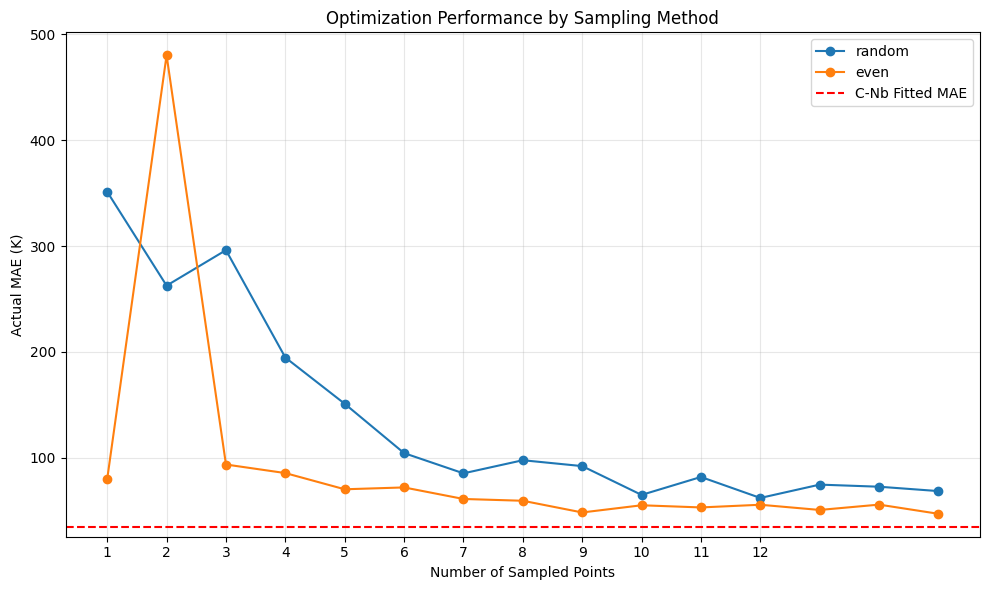

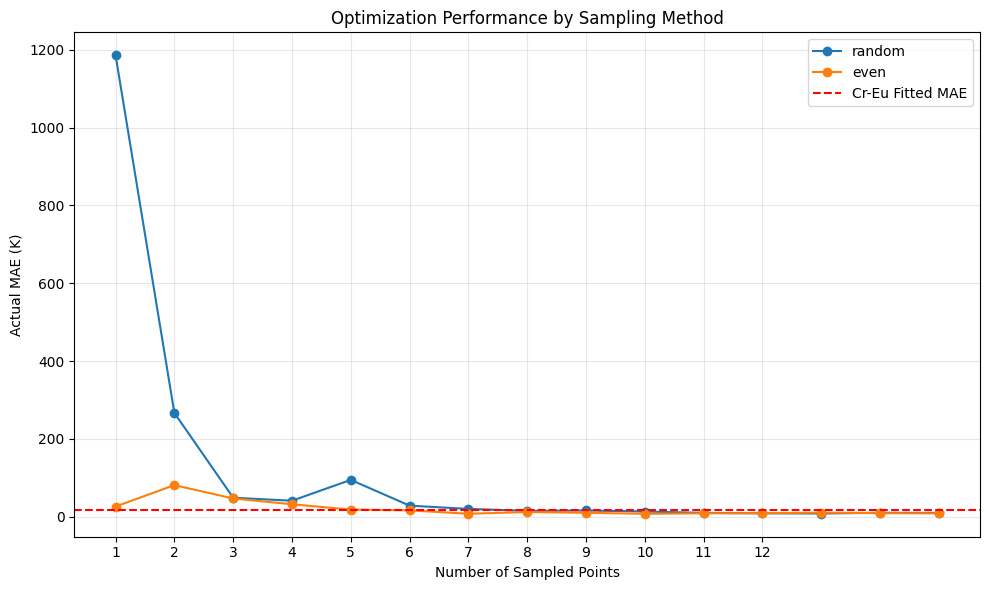

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

max_points = 15


# Define the file path
excel_file_path = r"C:\Users\willwerj\University of Michigan Dropbox\Joshua Willwerth\WHSun_Lab\G_liquid\matrix_data\predicted_system_data-AML8.xlsx"

# Check if file exists
if Path(excel_file_path).exists():
    # Load the Excel file into a DataFrame
    predicted_data_df = pd.read_excel(excel_file_path)
    print(f"Successfully loaded data with {predicted_data_df.shape[0]} rows and {predicted_data_df.shape[1]} columns")
else:
    print(f"Error: File not found at {excel_file_path}")


for sys_name in investigation_systems:
    # Find the row matching the system name
    system_row = predicted_data_df[predicted_data_df['system'] == sys_name]
    
    # Check if the system exists in the dataframe
    if system_row.empty:
        print(f"Warning: System {sys_name} not found in the predicted data")
        continue
    
    # Extract parameter values
    parameter_guesses = [
        system_row['L0_a'].values[0],
        system_row['L0_b'].values[0],
        system_row['L1_a'].values[0],
        system_row['L1_b'].values[0]
    ]
    
    # Initialize system with extracted parameters
    system = BinaryLiquid.from_cache(sys_name, params=parameter_guesses)

    # Dictionary to store results for each sampling method
    results = {}

    # Run optimization for each sampling method
    for method_name, sampling_function in sampling_methods.items():
        print(f"\n--- Running {method_name} sampling method ---")
        

        if len(sampling_function(system.digitized_liq, max_points)) == 0:
            print(f"Warning: Not enough points to sample for {sys_name} using {method_name} method")
            continue

        # Initialize dataframe to store results
        df = pd.DataFrame(columns=['num_points', 'perceived_mae', 'actual_mae'])
        
        # Reset parameters before each method
        system.update_params(parameter_guesses)
        
        # Run optimization for various numbers of points
        if "random" in method_name:
            # For random methods, run 3 times with different seeds
            sampling_function

            iterations_df = []
            for seed_value in [0, 42, 123]:
                print(f"Running with seed {seed_value}")
                random.seed(seed_value)
                temp_df = pd.DataFrame(columns=['num_points', 'perceived_mae', 'actual_mae'])
                
                for i in range(1, max_points + 1):
                    known_points = sampling_function(system.digitized_liq, i)
                    print(f"Num sampled points: {i}")
                    adjusted_params, perceived_mae, actual_mae = optimize_predicted_params(system, known_points)
                    
                    # Store results in dataframe
                    temp_df.loc[i] = [i, perceived_mae, actual_mae]
                    
                    print(f"Perceived MAE: {int(perceived_mae)}K, Actual MAE: {int(actual_mae)}K")
                iterations_df.append(temp_df)
            
            # Average the results from the 3 iterations
            df = pd.DataFrame(columns=['num_points', 'perceived_mae', 'actual_mae'])
            for i in range(1, max_points + 1):
                avg_perceived = sum(df.loc[i, 'perceived_mae'] for df in iterations_df) / 3
                avg_actual = sum(df.loc[i, 'actual_mae'] for df in iterations_df) / 3
                df.loc[i] = [i, avg_perceived, avg_actual]
        else:
            # For deterministic methods, run once
            for i in range(1, max_points + 1):
                known_points = sampling_function(system.digitized_liq, i)
                print(f"Num sampled points: {i}")

                adjusted_params, perceived_mae, actual_mae = optimize_predicted_params(system, known_points)
                
                # Store results in dataframe
                df.loc[i] = [i, perceived_mae, actual_mae]
                
                print(f"Perceived MAE: {int(perceived_mae)}K, Actual MAE: {int(actual_mae)}K")
        
        # Store dataframe in results dictionary
        results[method_name] = df
        
        # Save to Excel file
        excel_path = os.path.join(data_dir, f"{sys_name}_optimization_{method_name}.xlsx")
        df.to_excel(excel_path, index=False)
        print(f"Saved results to {excel_path}")

    # Create comparison plot
    plt.figure(figsize=(10, 6))

    for method_name, df in results.items():
        plt.plot(df['num_points'], df['actual_mae'], marker='o', label=f"{method_name}")

    if sys_name in fitting_results:
        mae_value = fitting_results[sys_name]['mae']
        plt.axhline(y=mae_value, color='red', linestyle='--', label=f"{sys_name} Fitted MAE")

    plt.xlabel('Number of Sampled Points')
    plt.xticks(range(1, 13))  # Set x-ticks to integers 1 through 12
    plt.ylabel('Actual MAE (K)')
    plt.title('Optimization Performance by Sampling Method')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # Save the plot
    plt.savefig(os.path.join(data_dir, f"{sys_name}_optimization_comparison.png"))


